In [ ]:
import earthkit.hydro as ekh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit.plots.quickplot as qplot

np.random.seed(1)

# helper function to create plots
def plot(data, norm=mpl.colors.LogNorm()):
    _, ax = plt.subplots()
    ax.contourf(data, norm=norm)
    ax.invert_yaxis()
    ax.grid(False)
    plt.axis("off")
    plt.show()

# Fields Defined on River Networks

In earthkit-hydro, a river network is defined on a specific grid. All fields for any operations in earthkit-hydro are assumed to also be on this same grid i.e. any interpolation/regridding is assumed to have been done already.

Multidimensional (vector) fields are supported for all operations in earthkit-hydro. It is assumed that the inputted field is of shape `(dim1, dim2, ..., grid_x_size, grid_y_size)` i.e. the last two axes must be the river network grid, and all other variables such as timestep or ensemble member must be present in earlier axes.

# River Network Creation

There are two ways to make a river network, `river_network.load` (preferred) and `river_network.create` (for special use cases). `river_network.load` loads a precomputed optimised version of a river network, whilst `river_network.create` creates a river network from an input file. Unless the river network you wish to use is not provided by `river_network.load`, please use `river_network.load`.

You can also use the alias `load_river_network` instead of `river_network.load`, and `create_river_network` instead of `river_network.create`.

In [2]:
river_network = ekh.river_network.load(domain="efas", river_network_version="5")

River network not found in cache (/var/folders/td/yqnxcqpx39dc855vwjtv5hj40000gn/T/tmph_b78rqr_earthkit_hydro/0.1_ea6b02b5935bacc00a2bd85aa78790267760263c88ebcac1cf425e5bcc773645.joblib).
River network loaded, saving to cache (/var/folders/td/yqnxcqpx39dc855vwjtv5hj40000gn/T/tmph_b78rqr_earthkit_hydro/0.1_ea6b02b5935bacc00a2bd85aa78790267760263c88ebcac1cf425e5bcc773645.joblib).


# Calculating Upstream Metrics

Given a river network, a common task is to compute an upstream sum, average or other metric for a field. In earthkit-hydro, this is easily possible. For example, to compute the upstream sum, one can use `upstream.sum` and analagously for `mean`, `max`, `min` and `product`.

It is also possible to use the lower-level function `calculate_upstream_metric`.

These functions take as input a field upon which to calculate the metric, and return a field.

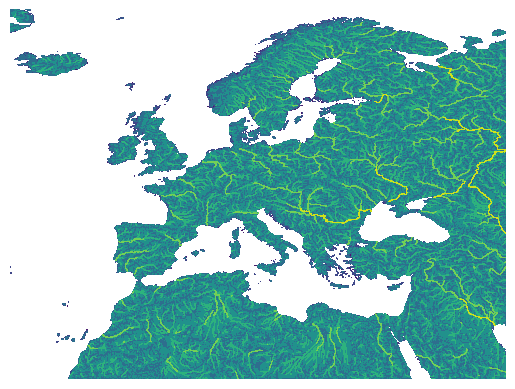

In [3]:
# create or load a field of interest e.g. area, precipitation, discharge
# as an example, we provide a unit field over the domain
unit_field = np.ones(river_network.shape)

upstream_sum_field = ekh.upstream.sum(river_network, unit_field)

plot(upstream_sum_field)

We can also compute other metrics, such as weighted averages.

In [4]:
random_field = np.random.rand(*river_network.shape)
random_weights = np.random.rand(*river_network.shape)
upstream_sum_field = ekh.upstream.mean(river_network, random_field, weights=random_weights)

And earthkit-hydro also supports vector fields!

In [5]:
vector_field = np.random.rand(2, 3, *river_network.shape)
upstream_sum_field = ekh.upstream.max(river_network, vector_field)

# Calculating Catchment Metrics

Instead of computing the upstream metric over the entire field, often one is only interested in computing it for certain points (such as stations). The upstream points of a station define that station's catchment, hence we provide the functions `catchments.sum`, `catchments.max`, `catchments.min`, `catchments.mean` and `catchments.product`.

It is also possible to use the lower-level function `calculate_catchment_metric`.

These functions take as input a field, and return a dictionary of {station: metric} pairs.

In [6]:
stations = (np.array([1801, 886, 1621]), np.array([4529, 3999, 3298])) # same points as before
random_field = np.random.rand(2, *river_network.shape) # vector field
random_weights = np.random.rand(2, *river_network.shape) # vector field

catchment_metric_at_stations = ekh.catchments.mean(river_network, random_field, stations)
print(catchment_metric_at_stations)

{(np.int64(1801), np.int64(4529)): array([0.50034817, 0.50081842]), (np.int64(886), np.int64(3999)): array([0.50009099, 0.50173426]), (np.int64(1621), np.int64(3298)): array([0.49966111, 0.49992867])}


# Finding Catchments and Subcatchments

Another common task is finding the catchments or subcatchments defined by a series of points (possibly stations). In earthkit-hydro, this is readily available with `catchments.find` and `subcatchments.find`, respectively.

As an alias, one can use `find_catchments` instead of `catchments.find` and `find_subcatchments` instead of `subcatchments.find`.

In [7]:
# create or load the points of interest
points = np.zeros(river_network.shape)

# largest catchment's sink
points[1801, 4529] = 5  # given label 5
# point within largest catchment but not the sink
points[886, 3999] = 2 # given label 2
# separate catchment
points[1621, 3298] = 1 # given label 1

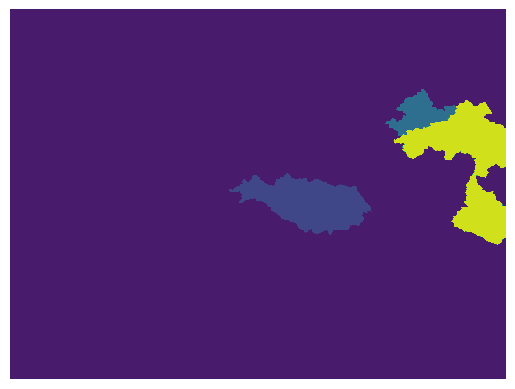

In [8]:
# find and plot the subcatchments
subcatchment_field = ekh.subcatchments.find(river_network, points)

plot(subcatchment_field, norm=None)

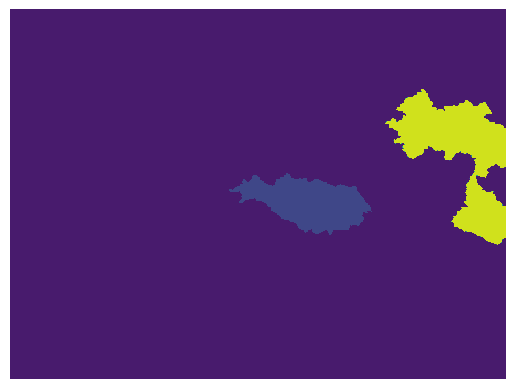

In [9]:
# find and plot the catchments
catchment_field = ekh.catchments.find(river_network, points)

plot(catchment_field, norm=None)

Again, vector fields are supported in earthkit-hydro for all operations.

In [10]:
# create or load the points of interest
# same points as before
points = np.zeros((2, *river_network.shape))

points[0, 1801, 4529] = 5
points[0, 886, 3999] = 2
points[0, 1621, 3298] = 1
points[1, 1801, 4500] = 3
points[1, 886, 3999] = 4

subcatchment_field = ekh.subcatchments.find(river_network, points)

# Computing Subcatchment Metrics

Finding subcatchments is useful, but often one is specifically interested in computing a metric over the subcatchments.

Analagously to catchments, earthkit-hydro provides `subcatchments.sum`, `subcatchments.max`, `subcatchments.min`, `subcatchments.mean` and `subcatchments.product`.

It is also possible to use the lower-level function `calculate_subcatchment_metric`.

In [11]:
stations = (np.array([1801, 886, 1621]), np.array([4529, 3999, 3298])) # same points as before
random_field = np.random.rand(2, *river_network.shape) # vector field
random_weights = np.random.rand(2, *river_network.shape) # vector field

subcatchment_metric_at_stations = ekh.subcatchments.mean(river_network, random_field, stations)
print(subcatchment_metric_at_stations)

{(np.int64(1801), np.int64(4529)): array([0.499677  , 0.49885923]), (np.int64(886), np.int64(3999)): array([0.49990883, 0.50008835]), (np.int64(1621), np.int64(3298)): array([0.4994701, 0.5005746])}


# Computing Zonal Metrics

If one wishes to compute a metric over an arbitrary area that isn't a catchment or subcatchment, this is also possible with `zonal.sum`, `zonal.max`, `zonal.min`, `zonal.mean` and `zonal.product`.

It is also possible to use the lower-level function `calculate_zonal_metric`.

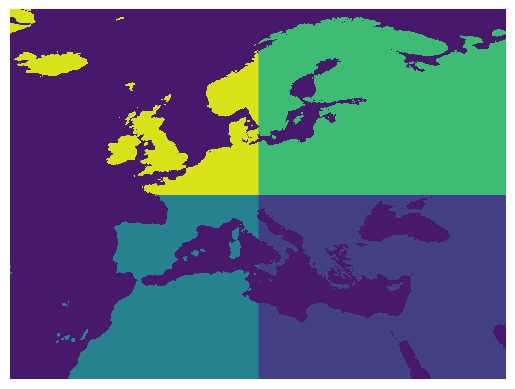

In [12]:
# generate some labelled regions defining where to compute the metric on
labels = np.empty(river_network.shape)
labels[river_network.shape[0]//2:, river_network.shape[1]//2:] = 1
labels[river_network.shape[0]//2:, :river_network.shape[1]//2] = 2
labels[:river_network.shape[0]//2, river_network.shape[1]//2:] = 3
labels[:river_network.shape[0]//2, :river_network.shape[1]//2] = 4
labels_missing_value = 0
labels[~river_network.mask] = labels_missing_value # give anything outside the river network a missing value of 0

plot(labels, norm=None)

In [13]:
random_field = np.random.rand(*river_network.shape)

metric_for_labels = ekh.zonal.mean(random_field, labels, labels_mv=labels_missing_value)
print(metric_for_labels)

{np.float64(1.0): np.float64(0.5003056284124306), np.float64(2.0): np.float64(0.5000677450442345), np.float64(3.0): np.float64(0.5000362037796515), np.float64(4.0): np.float64(0.4997197769723488)}


And we can return as a field instead of a dictionary if desired.

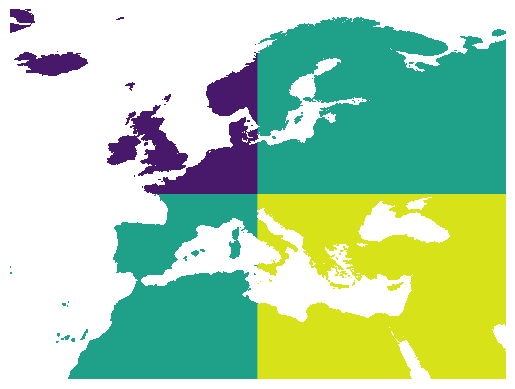

In [14]:
metric_field = ekh.zonal.mean(random_field, labels, labels_mv=labels_missing_value, return_field=True)

plot(metric_field, norm=None)

# Subnetwork

Another common function is to compute a subnetwork of the original river network, which is easily possible using the `create_subnetwork` method of the river network.

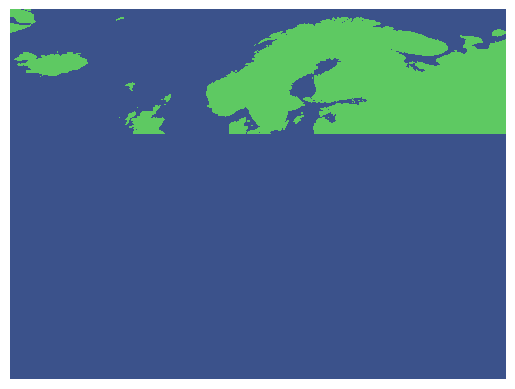

In [15]:
# create a subnetwork given a mask of northern Europe
mask = np.full(river_network.shape, False)
mask[:1000] = True
north_europe_river_network = river_network.create_subnetwork(mask)

plot(north_europe_river_network.mask, norm=None)

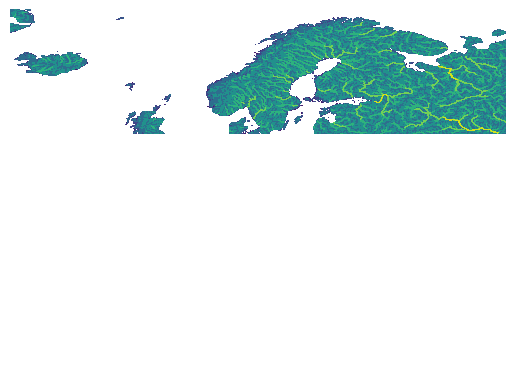

In [16]:
# compute the upstream sum on this new river network
upstream_sum_field = ekh.upstream.sum(north_europe_river_network, unit_field)
plot(upstream_sum_field)

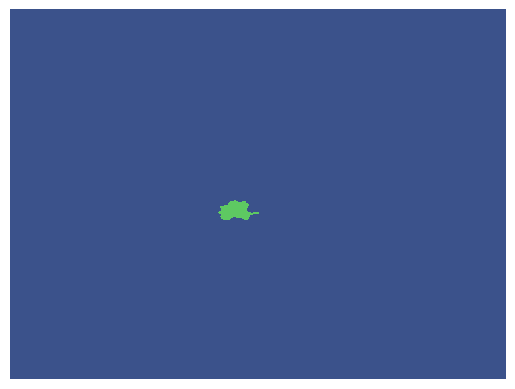

In [17]:
# create a subnetwork of a river catchment
# can find the mask directly by doing catchment with boolean arrays
points = np.full(river_network.shape, False)
points[1636, 2267] = True  # Po river catchment sink
catchment_mask = ekh.catchments.find(river_network, points, mv=False)
po_catchment_network = river_network.create_subnetwork(catchment_mask)
plot(po_catchment_network.mask, norm=None)

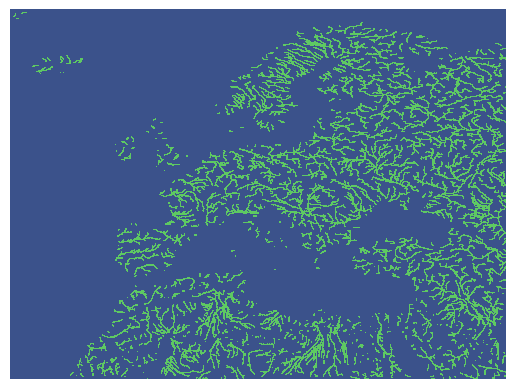

In [18]:
# create a subnetwork of large rivers only
accuflux_field = ekh.upstream.sum(river_network, unit_field)
large_rivers = accuflux_field > 1000
large_river_network = river_network.create_subnetwork(large_rivers)
plot(large_river_network.mask, norm=None)

# Upstream & Downstream

It is also possible to move a river network downstream or upstream with the `move_downstream` and `move_upstream` methods, respectively.

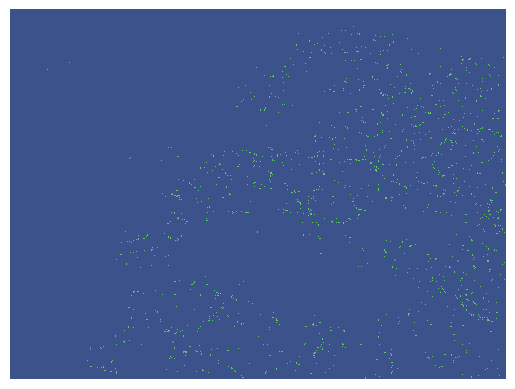

In [19]:
# find confluences of the large rivers
upstream_field = ekh.move_downstream(large_river_network, unit_field)
plot(upstream_field > 1, norm=None)

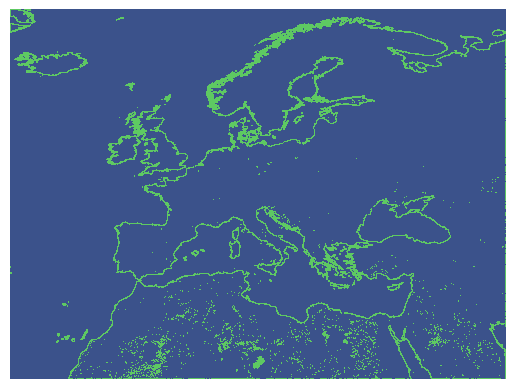

In [20]:
# find sinks of the original river network
downstream_field = ekh.move_upstream(river_network, unit_field)
plot(downstream_field == 0, norm=None)

And of course these support vector fields also.

In [21]:
random_field = np.random.rand(3,4,*river_network.shape)
downstream_field = ekh.move_upstream(river_network, random_field)

# Example with Earthkit and Precipitation Maps

Finally, earthkit-hydro is part of the earthkit ecosystem and interplays with other earthkit packages.

In [22]:
style = ekp.styles.Style(
    colors="Blues",
    levels=[0, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000, 2000, 3000, 4000],
    extend="max",
)

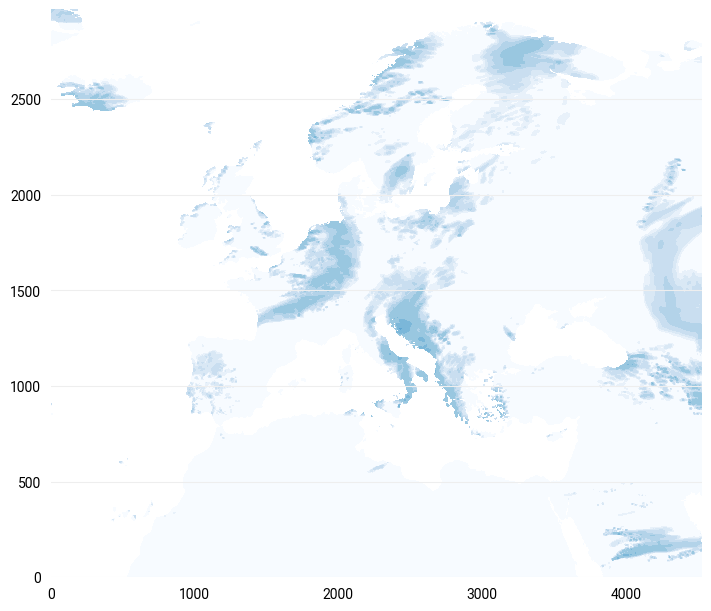

In [23]:
precipitation_field = ekd.from_source(
    "file",
    "example_precipitation.nc",
)[0].to_numpy()

qplot.contourf(precipitation_field[::-1, :], style=style)

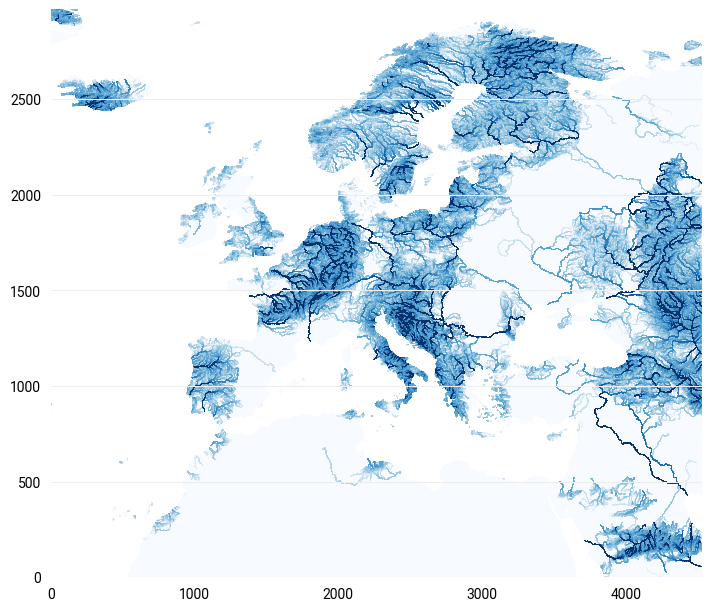

In [24]:
accuflux_field = ekh.flow_downstream(river_network, precipitation_field)
qplot.contourf(accuflux_field[::-1, :], style=style)